In [ ]:
# 📦 Imports
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

MAIN_DIR = "[path]"

COLORS = {
    "gray": "#363636",
    "blue": "#406c80",
    "orange": "#cf8532",
    "red": "#c94c4c",
    "green": "#70BE6B",
    "purple": "#786797"
}

# Cartelle
image_dir = MAIN_DIR + "data/images"
label_dir = MAIN_DIR + "data/labels"

# Classi YOLO
classes = ["pothole", "crack", "manhole"]

# Lettura delle annotazioni
annotations = []

label_files = glob.glob(os.path.join(label_dir, "*.txt"))

for label_path in tqdm(label_files):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        image_name = os.path.splitext(os.path.basename(label_path))[0]
        for line_num, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) != 9:
                print(f"❗ Skipping malformed line in {label_path} (line {line_num+1}): {line.strip()}")
                continue
            try:
                cls = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                x1 = float(parts[1])
                y1 = float(parts[2])
                x3 = float(parts[5])
                y3 = float(parts[6])
                
                width = abs(x3 - x1)
                height = abs(y3 - y1)

                annotations.append({
                    "image": image_name,
                    "class_id": cls,
                    "class_name": classes[cls],
                    "x": x_center,
                    "y": y_center,
                    "width": width,
                    "height": height,
                    "area": width * height,
                    "source": "gopro" if image_name.startswith("vlc") else "smartphone"
                })
            except Exception as e:
                print(f"⚠️ Errore nel parsing di {label_path} (line {line_num+1}): {e}")
                continue

df = pd.DataFrame(annotations)
df.head()

  0%|          | 0/2009 [00:00<?, ?it/s]

,image,class_id,class_name,x,y,width,height,area,source
0,vlcsnap-2025-02-19-14h13m52s026,0,pothole,0.284375,0.541667,0.050000,0.036111,0.001806,gopro
1,vlcsnap-2025-02-19-14h13m52s026,0,pothole,0.489063,0.561111,0.093749,0.041667,0.003906,gopro
2,vlcsnap-2025-02-19-14h13m52s026,0,pothole,0.753125,0.666667,0.125000,0.086111,0.010764,gopro
3,vlcsnap-2025-02-19-14h13m52s026,1,crack,0.632812,0.666667,0.092188,0.091666,0.008451,gopro
4,20250223_143958,1,crack,0.187500,0.244444,0.492188,0.750000,0.369141,smartphone


In [2]:
print("Total number of images:", len(df["image"].unique()))
print("Total number of annotations:", len(df))

df["class_name"].value_counts()

Total number of images: 2009
Total number of annotations: 4737


class_name
crack      2519
pothole    1261
manhole     957
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


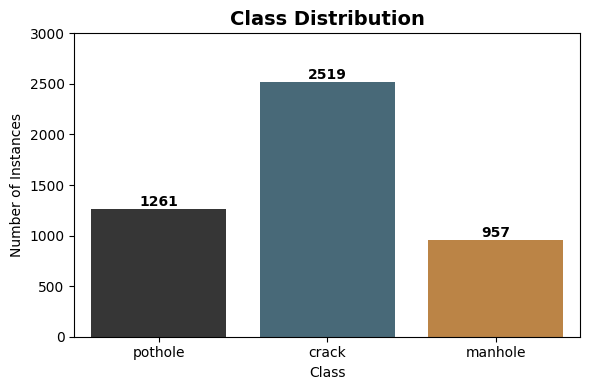

In [8]:
plt.figure(figsize=(6, 4))

# Countplot con colori personalizzati
ax = sns.countplot(
    data=df,
    x="class_name",
    hue="class_name",
    palette=COLORS.values(),
    dodge=False
)

# Etichette sopra ogni barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Class Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.ylim(0, 3000)
plt.legend().remove()  # Rimuove legenda duplicata
plt.tight_layout()

# --- Salvataggio ---
plt.savefig("classDistribution.png", dpi=300)
plt.show()

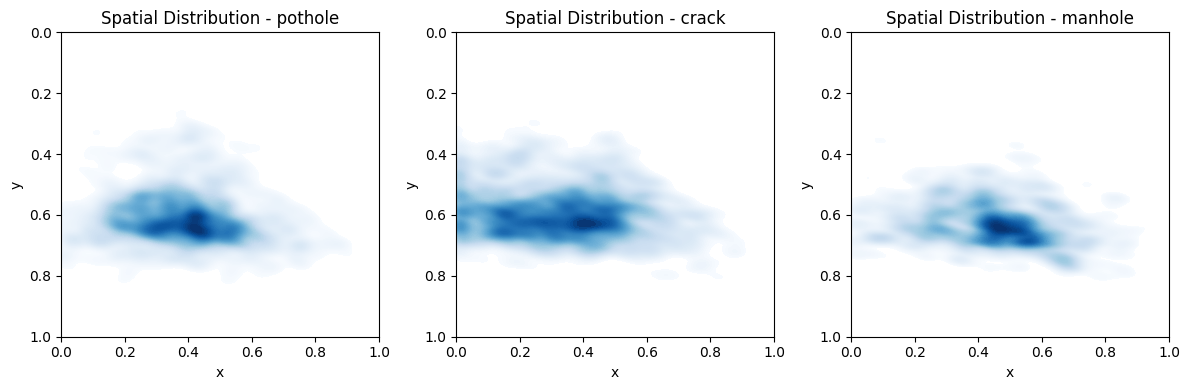

In [5]:
plt.figure(figsize=(12, 4))
for i, cls in enumerate(df["class_name"].unique()):
    plt.subplot(1, 3, i+1)
    subset = df[df["class_name"] == cls]
    sns.kdeplot(
        x=subset["x"], 
        y=subset["y"], 
        fill=True, 
        cmap="Blues", 
        bw_adjust=0.5, 
        levels=100, 
        thresh=0.05
    )
    plt.title(f"Spatial Distribution - {cls}")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()  # Inverte l'asse y
    plt.xlabel("x")
    plt.ylabel("y")

plt.tight_layout()

# Salva l'immagine a 300 dpi
plt.savefig("./results/images/spatial_distribution_classes.png", dpi=200, bbox_inches='tight', facecolor='white')

plt.show()

## Directly from yolo training

<img src="./pothole-dataset-yolo.jpg" width=900px>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


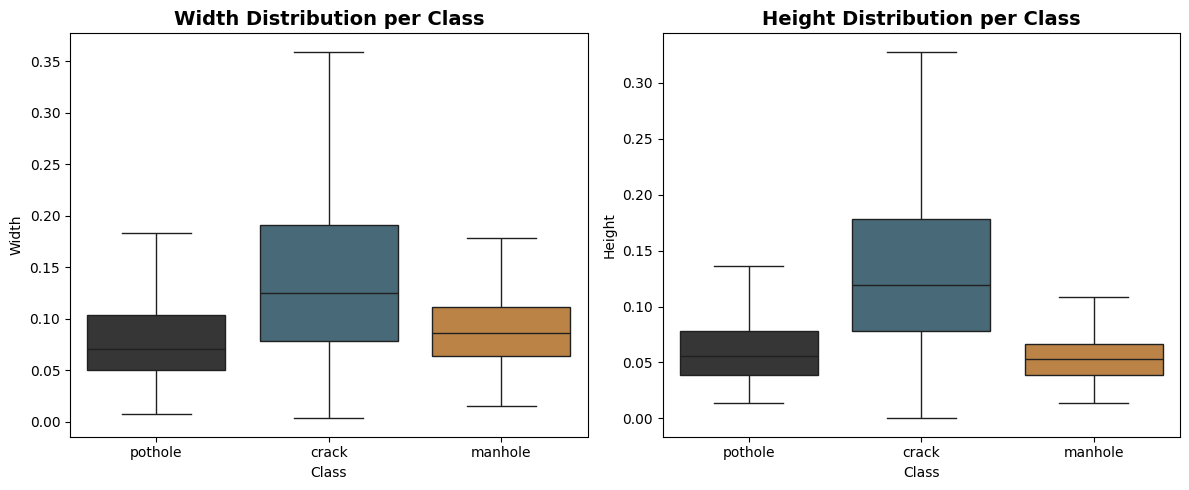

In [ ]:
plt.figure(figsize=(12, 5))

# Left plot: Width distribution
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df,
    x="class_name",
    y="width",
    hue="class_name",
    palette=COLORS.values(),
    dodge=False,
    showfliers=False
)
plt.title("Width Distribution per Class", fontsize=14, fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Width")
plt.legend().remove()  # Remove legend

# Right plot: Height distribution
plt.subplot(1, 2, 2)
sns.boxplot(
    data=df,
    x="class_name",
    y="height",
    hue="class_name",
    palette=COLORS.values(),
    dodge=False,
    showfliers=False
)
plt.title("Height Distribution per Class", fontsize=14, fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Height")
plt.legend().remove()  # Remove legend

plt.tight_layout()

# --- Salvataggio ---
plt.savefig("widthHeightDistributionPerClass.png", dpi=300)
plt.show()

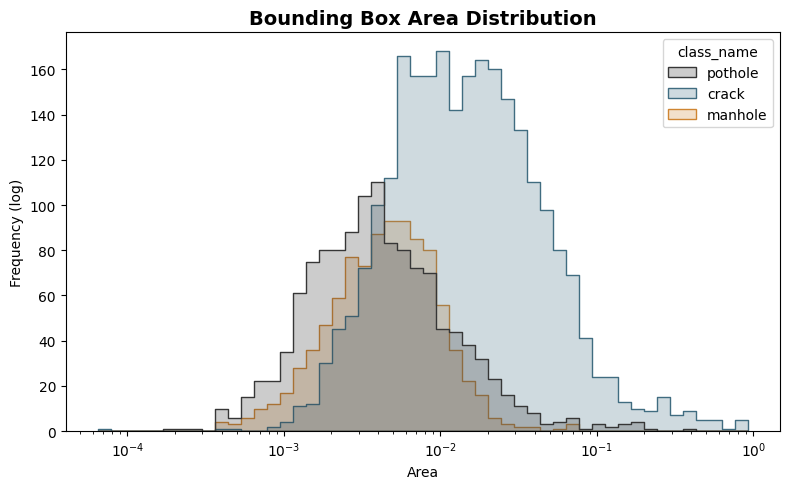

In [13]:
plt.figure(figsize=(8, 5))

# Histogram con colori personalizzati
sns.histplot(
    data=df,
    x="area",
    hue="class_name",
    bins=50,
    element="step",
    log_scale=True,
    palette=[COLORS['gray'], COLORS['blue'], COLORS['orange']]
)

plt.title("Bounding Box Area Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Area")
plt.ylabel("Frequency (log)")
plt.tight_layout()

# --- Salvataggio ---
plt.savefig("boundingBoxAreaDistribution.png", dpi=300)
plt.show()

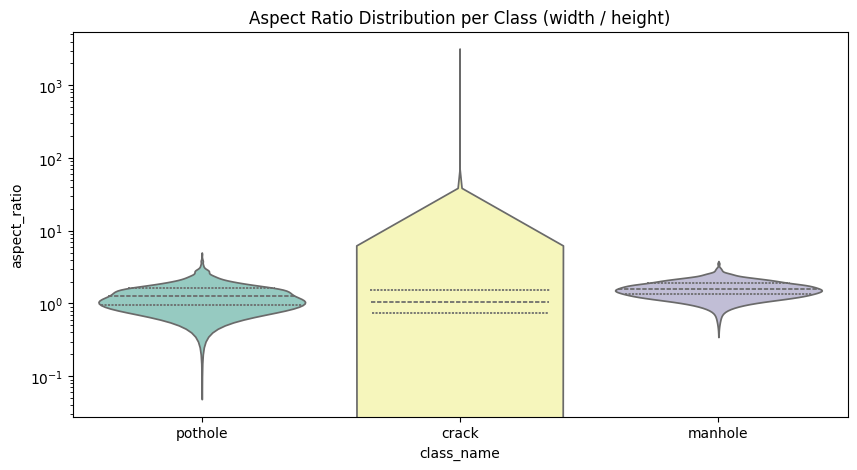

In [8]:
df["aspect_ratio"] = df["width"] / (df["height"] + 1e-6)

plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="class_name", hue="class_name", y="aspect_ratio", palette="Set3", inner="quart")
plt.title("Aspect Ratio Distribution per Class (width / height)")
plt.yscale("log")
plt.show()

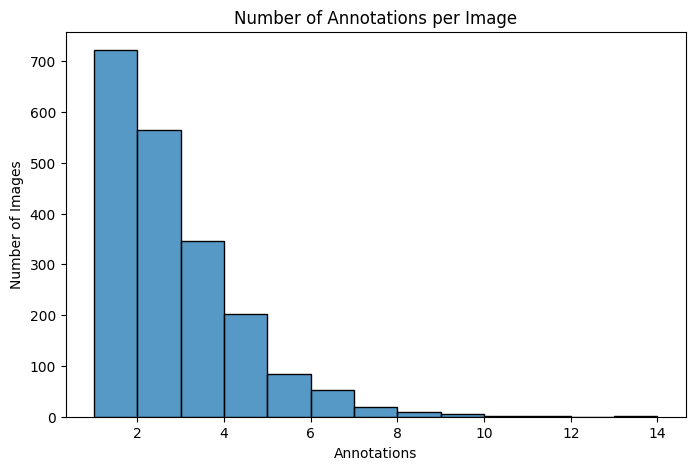

In [9]:
ann_per_image = df.groupby("image")["class_id"].count()

plt.figure(figsize=(8, 5))
sns.histplot(ann_per_image, bins=range(1, ann_per_image.max()+2), kde=False)
plt.title("Number of Annotations per Image")
plt.xlabel("Annotations")
plt.ylabel("Number of Images")
plt.show()

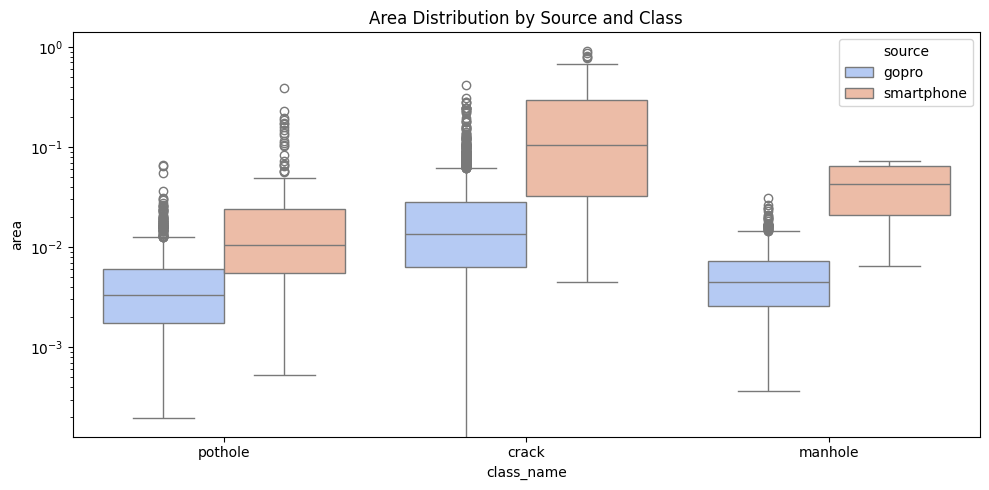

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="class_name", y="area", hue="source", palette="coolwarm")
plt.yscale("log")
plt.title("Area Distribution by Source and Class")
plt.tight_layout()
plt.show()

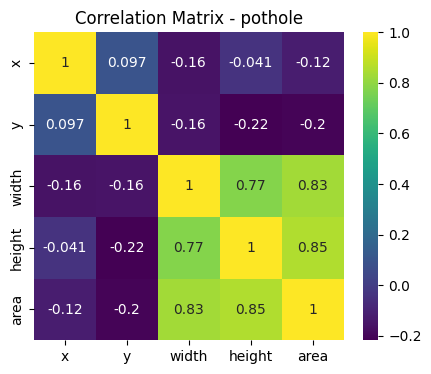

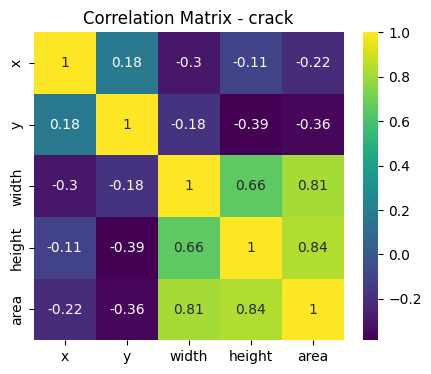

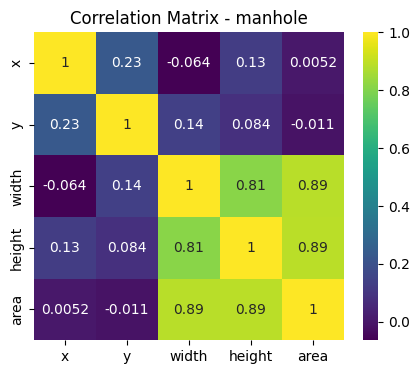

In [11]:
for cls in df["class_name"].unique():
    subset = df[df["class_name"] == cls]
    plt.figure(figsize=(5, 4))
    sns.heatmap(subset[["x", "y", "width", "height", "area"]].corr(), annot=True, cmap="viridis")
    plt.title(f"Correlation Matrix - {cls}")
    plt.show()

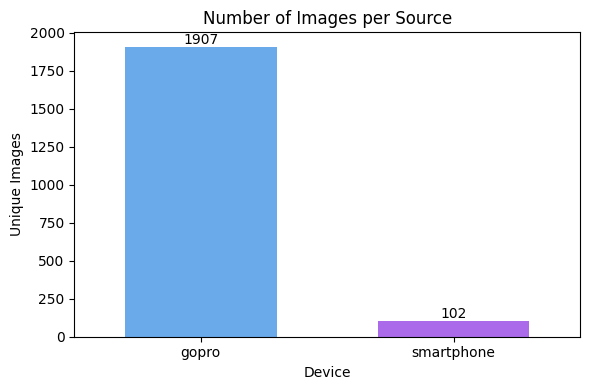

In [8]:
unique_images = df.drop_duplicates(subset="image")

plt.figure(figsize=(6, 4))
ax = sns.countplot(
    data=unique_images,
    x="source",
    hue="source",
    palette="cool",
    width=0.6  # ← rende le barre più strette
)

# Aggiungi le etichette sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title("Number of Images per Source")
plt.ylabel("Unique Images")
plt.xlabel("Device")
plt.tight_layout()
plt.show()

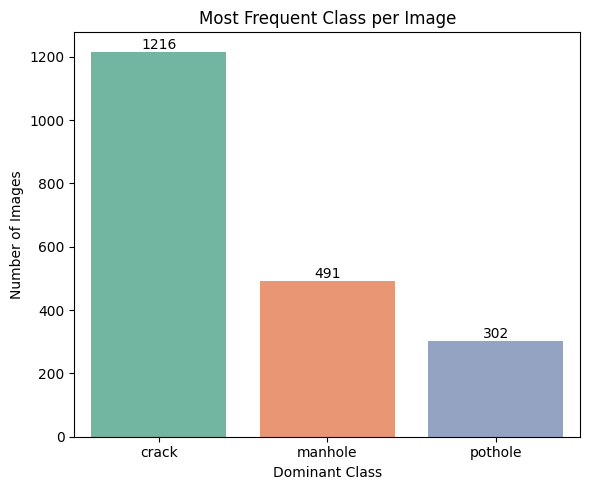

In [9]:
mode_class = df.groupby("image")["class_name"].agg(lambda x: x.mode()[0])
mode_df = mode_class.value_counts().reset_index()
mode_df.columns = ["Dominant Class", "Number of Images"]

plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=mode_df,
    x="Dominant Class",
    y="Number of Images",
    hue="Dominant Class",
    palette="Set2"
)

# Aggiungi etichette sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title("Most Frequent Class per Image")
plt.tight_layout()
plt.show()

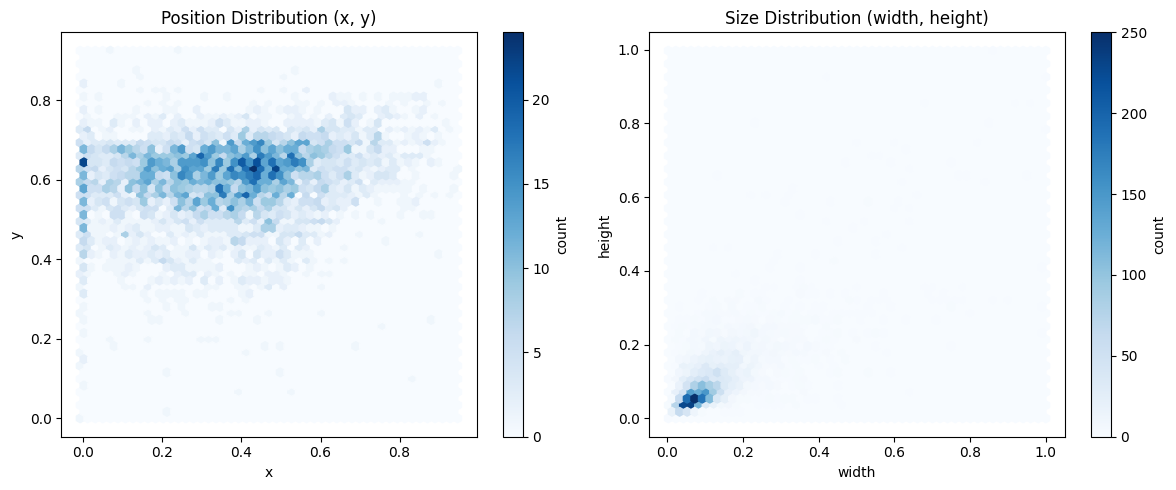

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hexbin(df["x"], df["y"], gridsize=50, cmap="Blues")
plt.title("Position Distribution (x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="count")

plt.subplot(1, 2, 2)
plt.hexbin(df["width"], df["height"], gridsize=50, cmap="Blues")
plt.title("Size Distribution (width, height)")
plt.xlabel("width")
plt.ylabel("height")
plt.colorbar(label="count")

plt.tight_layout()
plt.show()

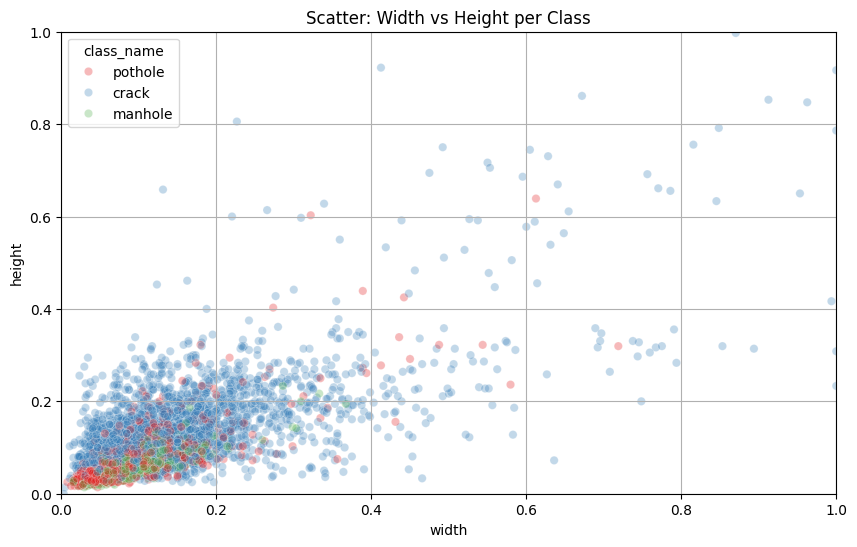

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="width", y="height", hue="class_name", alpha=0.3, palette="Set1")
plt.title("Scatter: Width vs Height per Class")
plt.xlabel("width")
plt.ylabel("height")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

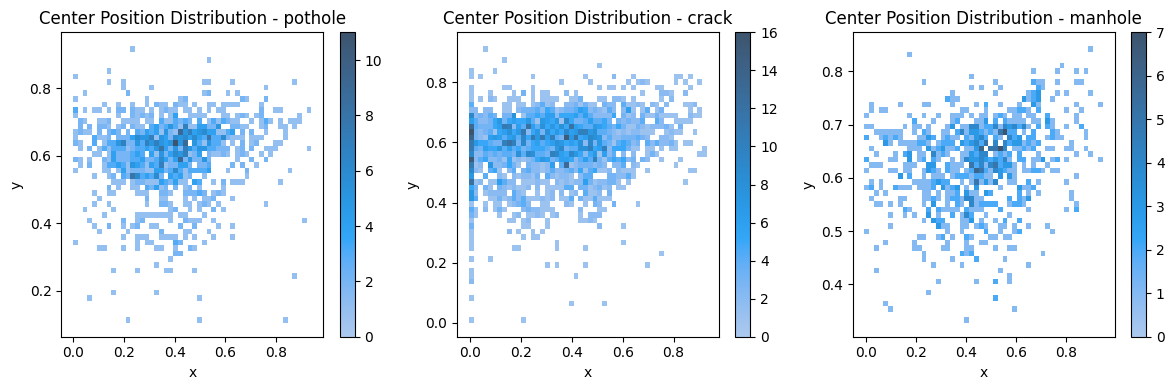

In [16]:
plt.figure(figsize=(12, 4))
for i, cls in enumerate(df["class_name"].unique()):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df[df["class_name"] == cls], x="x", y="y", bins=50, cbar=True)
    plt.title(f"Center Position Distribution - {cls}")
    plt.xlabel("x")
    plt.ylabel("y")
plt.tight_layout()
plt.show()

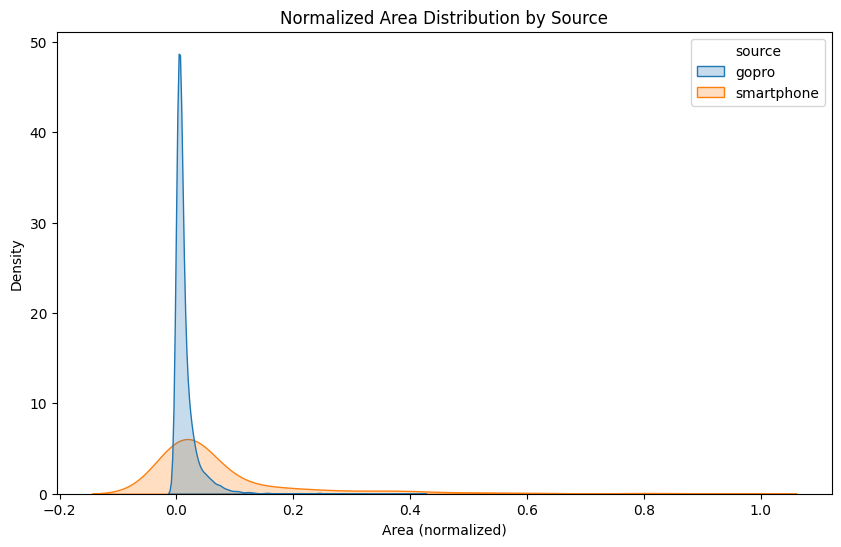

In [17]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="area", hue="source", log_scale=False, fill=True, common_norm=False, warn_singular=False)
plt.title("Normalized Area Distribution by Source")
plt.xlabel("Area (normalized)")
plt.show()

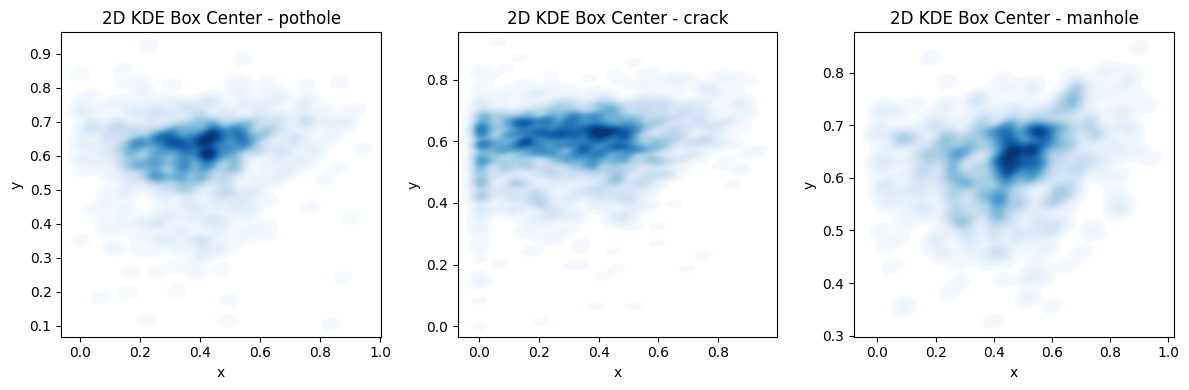

In [18]:
plt.figure(figsize=(12, 4))
for i, cls in enumerate(df["class_name"].unique()):
    subset = df[df["class_name"] == cls]
    plt.subplot(1, 3, i+1)
    sns.kdeplot(x=subset["x"], y=subset["y"], fill=True, cmap="Blues", bw_adjust=0.4, levels=100, thresh=0.01)
    plt.title(f"2D KDE Box Center - {cls}")
    plt.xlabel("x")
    plt.ylabel("y")
plt.tight_layout()
plt.show()

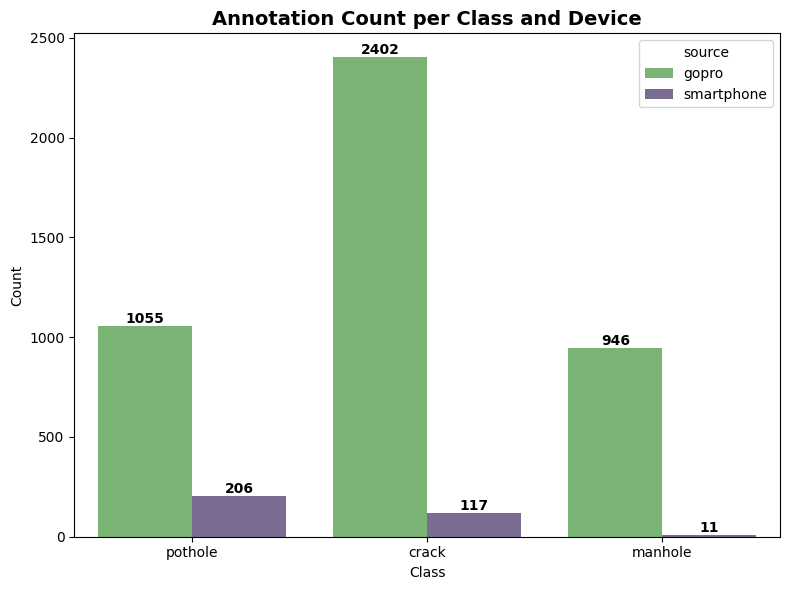

In [20]:
plt.figure(figsize=(8, 6))

# Usa colori personalizzati per le classi
unique_sources = sorted(df['source'].unique())
palette = [COLORS['green'], COLORS['purple']]
palette = palette[:len(unique_sources)]  # taglia la palette al numero di fonti

ax = sns.countplot(
    data=df,
    x="class_name",
    hue="source",
    palette=palette
)

# Annotazioni sopra le barre
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{int(height)}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )

plt.title("Annotation Count per Class and Device", fontsize=14, fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()

# --- Salvataggio ---
plt.savefig("counts_per_class_and_device.png", dpi=300)
plt.show()

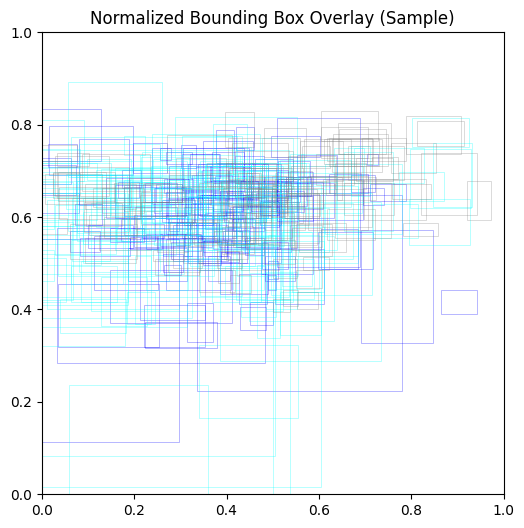

In [20]:
plt.figure(figsize=(6, 6))

colors = {"pothole": "blue", "crack": "cyan", "manhole": "gray"}
for cls in df["class_name"].unique():
    subset = df[df["class_name"] == cls]
    for _, row in subset.sample(n=min(150, len(subset)), random_state=1).iterrows():
        x0 = row["x"] - row["width"]/2
        y0 = row["y"] - row["height"]/2
        rect = plt.Rectangle((x0, y0), row["width"], row["height"],
                             edgecolor=colors[cls], facecolor='none', lw=0.5, alpha=0.4)
        plt.gca().add_patch(rect)
plt.title("Normalized Bounding Box Overlay (Sample)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.show()

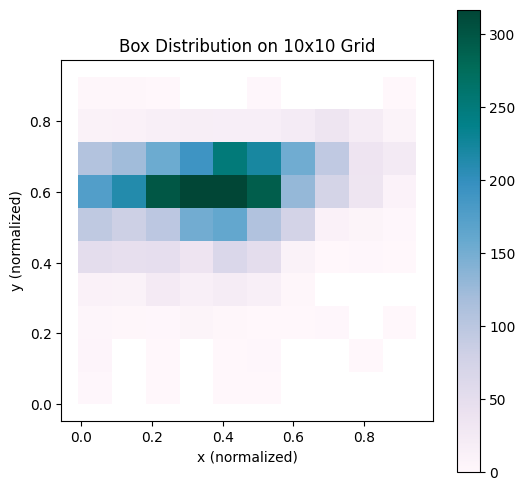

In [21]:
plt.figure(figsize=(6, 6))
sns.histplot(data=df, x="x", y="y", bins=10, pmax=0.9, cmap="PuBuGn", cbar=True)
plt.title("Box Distribution on 10x10 Grid")
plt.xlabel("x (normalized)")
plt.ylabel("y (normalized)")
plt.gca().set_aspect('equal')
plt.show()

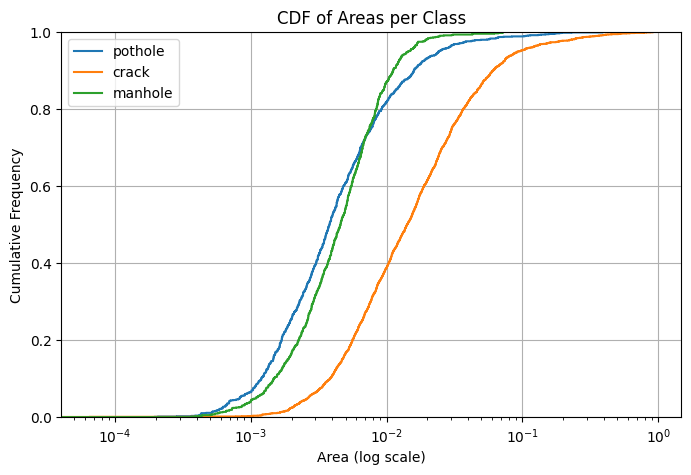

In [22]:
plt.figure(figsize=(8, 5))
for cls in df["class_name"].unique():
    sns.ecdfplot(data=df[df["class_name"] == cls], x="area", label=cls)
plt.xscale("log")
plt.title("CDF of Areas per Class")
plt.xlabel("Area (log scale)")
plt.ylabel("Cumulative Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Explanation of the t-SNE Plot

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique especially suited for visualizing high-dimensional data in a low-dimensional space (usually 2D or 3D).

**What t-SNE does:**

- **Goal:** Preserve the local structure of the original data. That means points that are similar in the high-dimensional space remain close together in the reduced space, while dissimilar points are far apart.
- **How it works:** t-SNE converts similarities between data points into joint probabilities and tries to minimize the divergence between these probabilities in the high-dimensional and low-dimensional spaces. It uses a Student's t-distribution in the low-dimensional space to alleviate the "crowding problem."

**In the context of this plot:**

- The features `x`, `y`, `width`, `height`, and `area` represent a 5-dimensional feature space.
- t-SNE reduces these 5 dimensions into 2 dimensions (`tsne-1` and `tsne-2`) for visualization.
- Each point on the plot represents a bounding box annotation, positioned such that points with similar features are near each other.
- The color (`hue="class_name"`) shows the class of each annotation, revealing how different classes cluster or overlap in the reduced space.

**Summary:**  
This plot helps visualize the structure and distribution of the annotations in the dataset, highlighting potential clusters or overlaps between classes.

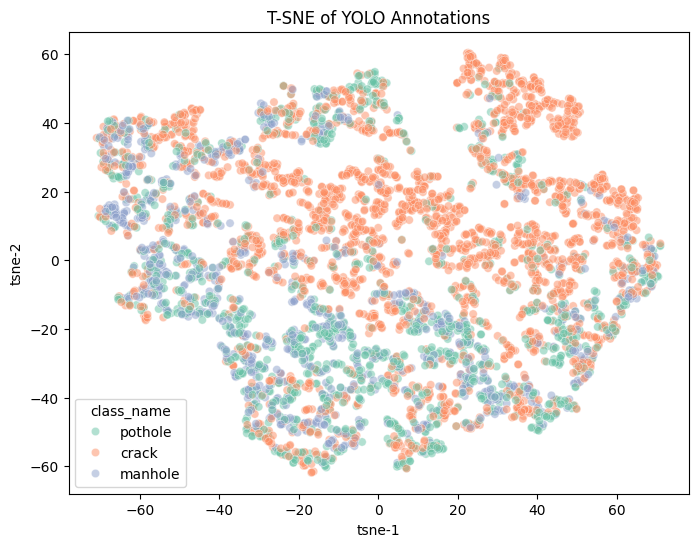

In [23]:
from sklearn.manifold import TSNE

features = df[["x", "y", "width", "height", "area"]]
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings = tsne.fit_transform(features)

df["tsne-1"] = embeddings[:, 0]
df["tsne-2"] = embeddings[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="tsne-1", y="tsne-2", hue="class_name", alpha=0.5, palette="Set2")
plt.title("T-SNE of YOLO Annotations")
plt.show()

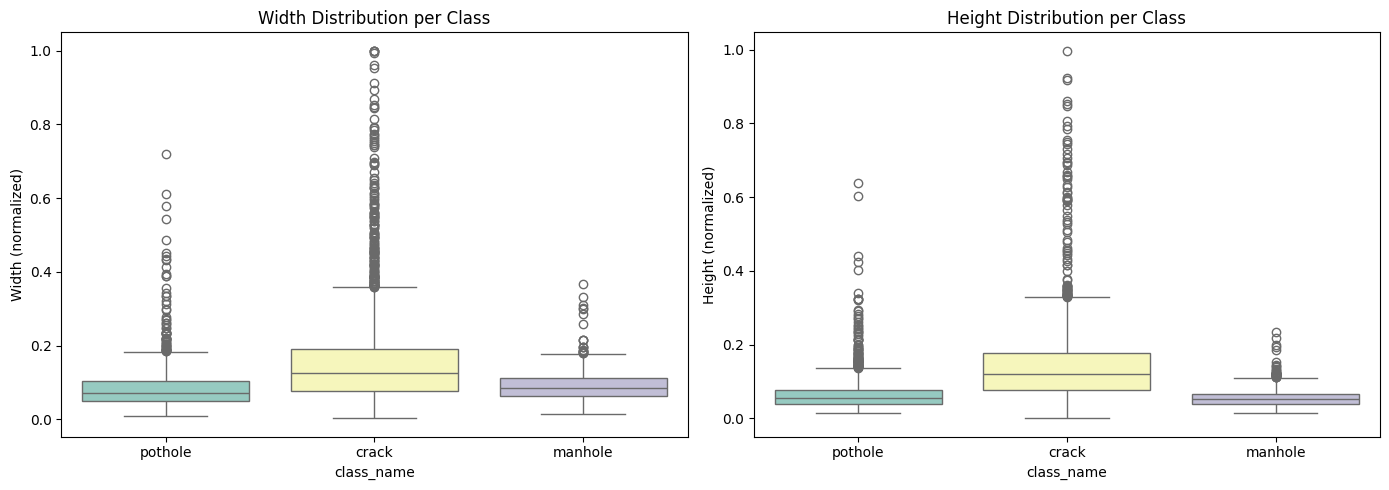

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df, x="class_name", hue="class_name", y="width", ax=axes[0], palette="Set3")
axes[0].set_title("Width Distribution per Class")
axes[0].set_ylabel("Width (normalized)")

sns.boxplot(data=df, x="class_name", y="height", hue="class_name", ax=axes[1], palette="Set3")
axes[1].set_title("Height Distribution per Class")
axes[1].set_ylabel("Height (normalized)")

plt.tight_layout()
plt.show()

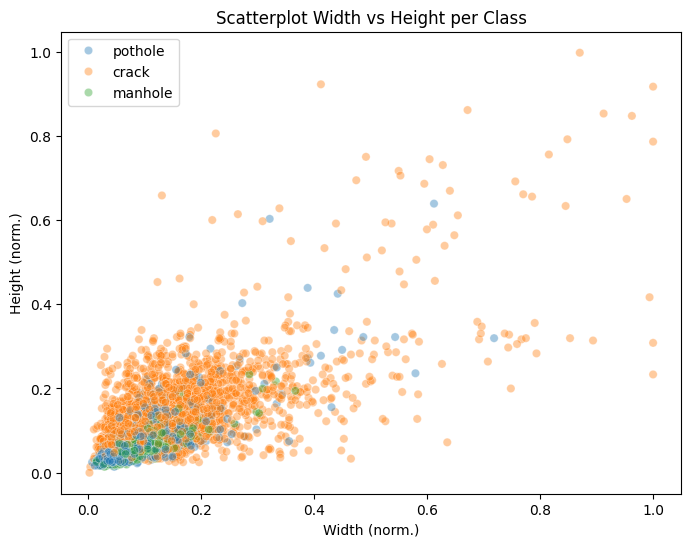

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="width", y="height", hue="class_name", alpha=0.4)
plt.title("Scatterplot Width vs Height per Class")
plt.xlabel("Width (norm.)")
plt.ylabel("Height (norm.)")
plt.legend()
plt.show()

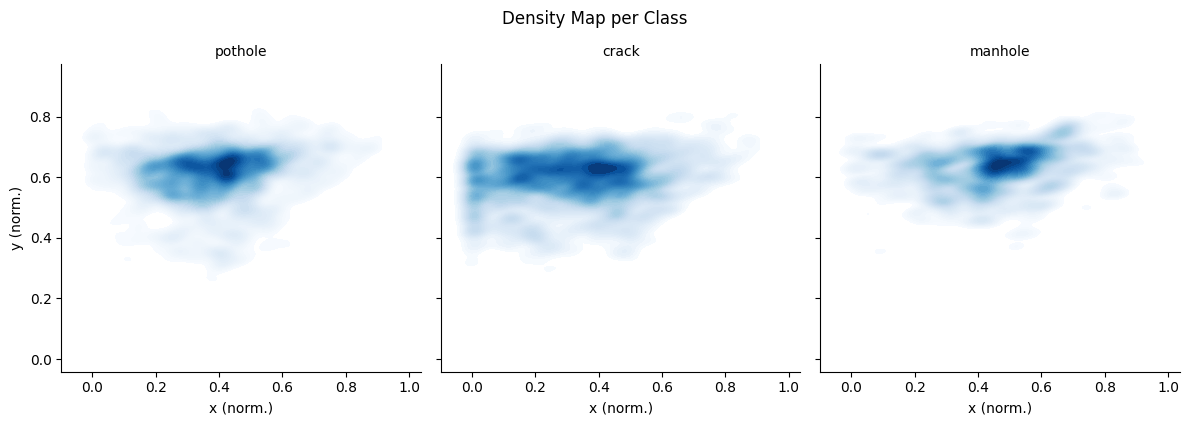

In [26]:
g = sns.FacetGrid(df, col="class_name", col_wrap=3, height=4)
g.map_dataframe(sns.kdeplot, x="x", y="y", fill=True, cmap="Blues", bw_adjust=0.5, levels=50, thresh=0.05)
g.set_axis_labels("x (norm.)", "y (norm.)")
g.set_titles("{col_name}")
g.fig.suptitle("Density Map per Class", y=1.05)
plt.show()